In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
from skimage import io, color
import pandas as pd
import os
from tqdm.notebook import tqdm

In [2]:
# Takes inputs with dims = (N, C, *)
# Gives outputs with dimes = (N, C, *)
class LocalResponseNormalization(nn.Module):
    def __init__(self, neighbourhood_length, normalisation_const_alpha, contrast_const_beta, noise_k):
        super(LocalResponseNormalization, self).__init__()
        self.nbd_len = neighbourhood_length
        self.alpha = normalisation_const_alpha
        self.beta = contrast_const_beta
        self.k = noise_k
    
    # The following is exactly what pytorch does under the hood as well. I only replicated it for my understanding :)
    def forward(self, x):
        # Lets validate if x is atleast 3 dimensional
        dim = x.dim()
        if dim < 3:
            raise ValueError("Expected tensor of atleast 3 dimensions, found only {}".format(dim))
        denom = x.pow(2).unsqueeze(1)
        if dim == 3:
            denom = F.pad(denom, (0, 0, self.nbd_len // 2, (self.nbd_len - 1) // 2))
            denom = F.avg_pool2d(denom, (self.nbd_len, 1), stride=1)
            denom = denom.squeeze(1)
        else:
            sizes = x.size()
            # The last two dimensions make up a single channel. The third dimension decides the number of channels
            # across which we will apply local response normalization.
            denom = denom.view(sizes[0], 1, sizes[1], sizes[2], -1)
            # The point is to pad in front and back of the channels across which we'll apply normalization
            denom = F.pad(denom, (0, 0, 0, 0, self.nbd_len // 2, (self.nbd_len - 1) // 2))
            denom = F.avg_pool3d(denom, (self.nbd_len, 1, 1), stride=1)
            denom = denom.squeeze(1).view(sizes)
        denom = denom.mul(self.alpha).add(self.k).pow(self.beta)
        return x.div(denom)

In [3]:
# Expects input tensor to be of dimensions (batch_size, 3, 224, 224)
class Alexnet(nn.Module):
    def __init__(self):
        super(Alexnet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=256 * 6 * 6, out_features=4096)
        self.fc2 = nn.Linear(in_features=4096, out_features=4096)
        self.fc3 = nn.Linear(in_features=4096, out_features=10)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2)
        # This layer helps us avoid calculating output map size when feeding into a linear layer in PyTorch.
        self.adaptive_pool = nn.AdaptiveAvgPool2d(output_size=(6, 6))
        self.norm = LocalResponseNormalization(neighbourhood_length=5, normalisation_const_alpha=1e-4, contrast_const_beta=0.75, noise_k=1.0)
        self.dropout = nn.Dropout()
    
    def forward(self, x):
        x = self.max_pool(self.norm(F.relu(self.conv1(x))))
        x = self.max_pool(self.norm(F.relu(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.adaptive_pool(self.norm(F.relu(self.conv5(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [4]:
class SceneDataset(Dataset):
    def __init__(self, annotations_csv, root_dir, transform=None):
        self.annotations = pd.read_csv(annotations_csv)
        self.root_dir = root_dir
        self.transform = transform
                    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        label = torch.tensor(int(self.annotations.iloc[index, 1]))
        if self.transform:
            image = self.transform(image)
        return [image, label]

In [5]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    # Don't forget to toggle to eval mode!
    model.eval()
    
    with torch.no_grad():
        for data, targets in tqdm(loader):
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print("Correct: {}, Total: {}, Accuracy: {}".format(num_correct, num_samples, int(num_correct) / int(num_samples)))
    # Don't forget to toggle back to model.train() since you're done with evaluation
    model.train()

In [6]:
if __name__ == '__main__':
    
    LEARNING_RATE = 0.0001
    # You could try playing around with the batch size(say 16) and learning rate(say 0.001) for faster convergence.
    BATCH_SIZE = 8
    EPOCHS = 10
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    transform_img = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    
    data = SceneDataset(annotations_csv="../input/scene-classification/train-scene classification/train.csv",
                          root_dir="../input/scene-classification/train-scene classification/train",
                          transform = transform_img)
    train_data, test_data = torch.utils.data.random_split(data, [12034, 5000])
    train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)
    
    alexnet = Alexnet()
    alexnet.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(alexnet.parameters(), lr=LEARNING_RATE) 
    
    data, targets = next(iter(train_loader))
    for epoch in tqdm(range(EPOCHS)):
        losses = []
        with tqdm(total=len(train_loader)) as pbar:
            for batch_idx, (data, targets) in enumerate(train_loader):
                data = data.to(device=device)
                targets = targets.to(device=device)

                scores = alexnet(data)
                loss = criterion(scores, targets)
                losses.append(loss)

                # backprop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
#                 print(loss.item())
                pbar.update(1)
        print("Cost at epoch {} is {}".format(epoch, sum(losses) / len(losses)))
        check_accuracy(train_loader, alexnet)
        check_accuracy(test_loader, alexnet)



Cost at epoch 0 is 1.1776070594787598



Correct: 6519, Total: 12034, Accuracy: 0.5417151404354329



Correct: 2662, Total: 5000, Accuracy: 0.5324



Cost at epoch 1 is 0.8313592076301575



Correct: 8369, Total: 12034, Accuracy: 0.6954462356656141



Correct: 3425, Total: 5000, Accuracy: 0.685



Cost at epoch 2 is 0.6572538018226624



Correct: 9275, Total: 12034, Accuracy: 0.7707329233837461



Correct: 3749, Total: 5000, Accuracy: 0.7498



Cost at epoch 3 is 0.5655052065849304



Correct: 9749, Total: 12034, Accuracy: 0.8101213229183979



Correct: 3900, Total: 5000, Accuracy: 0.78



Cost at epoch 4 is 0.48675429821014404



Correct: 10247, Total: 12034, Accuracy: 0.8515040717965764



Correct: 4063, Total: 5000, Accuracy: 0.8126



Cost at epoch 5 is 0.4278055727481842



Correct: 10569, Total: 12034, Accuracy: 0.8782615921555592



Correct: 4127, Total: 5000, Accuracy: 0.8254



Cost at epoch 6 is 0.3755890727043152



Correct: 10910, Total: 12034, Accuracy: 0.9065979724115008



Correct: 4202, Total: 5000, Accuracy: 0.8404



Cost at epoch 7 is 0.32411259412765503



Correct: 10989, Total: 12034, Accuracy: 0.9131627056672761



Correct: 4169, Total: 5000, Accuracy: 0.8338



Cost at epoch 8 is 0.2831090986728668



Correct: 11103, Total: 12034, Accuracy: 0.9226358650490277



Correct: 4153, Total: 5000, Accuracy: 0.8306



Cost at epoch 9 is 0.24313727021217346



Correct: 11429, Total: 12034, Accuracy: 0.9497257769652651



Correct: 4174, Total: 5000, Accuracy: 0.8348



In [9]:
import matplotlib.pyplot as plt

def show_image_and_prediction(img_path):
    idx2label = {0: "Buildings", 1: "Forests", 2: "Mountains", 3: "Glacier", 4: "Sea", 5: "Street"}
    img = io.imread(img_path)
    transformed_img = transform_img(img)
    out = alexnet(transformed_img.unsqueeze(0).to(device=device))
    _, pred = out.max(1)
    plt.imshow(img)
    plt.show()
    print("Hey Prajwal I think this scence contains: {}".format(idx2label[pred.item()]))


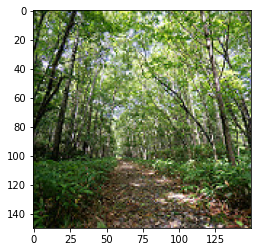

Hey Prajwal I think this scence contains: Forests


In [10]:
show_image_and_prediction("../input/scene-classification/train-scene classification/train/10010.jpg")

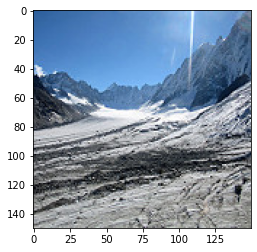

Hey Prajwal I think this scence contains: Mountains


In [11]:
show_image_and_prediction("../input/scene-classification/train-scene classification/train/10.jpg")

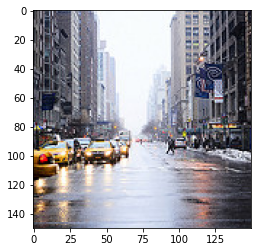

Hey Prajwal I think this scence contains: Street


In [12]:
show_image_and_prediction("../input/scene-classification/train-scene classification/train/37.jpg")


In [ ]:
show_image_and_prediction("../input/scene-classification/train-scene classification/train/85.jpg")